In [1]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



nu
[  0.47317561   0.47364167   0.47410864 ... 236.37079595 236.50620759
 236.64158153]
Tsig
[ 0.00000000e+00 -8.56770291e-09 -8.51986238e-09 ...  2.65184016e-03
  2.64729438e-03  2.64276187e-03]
[ 0.47317561  0.47364167  0.47410864 ... 49.79705315 49.85427452
 49.96878272]
[ 0.00000000e+00 -8.56770291e-09 -8.51986238e-09 ... -1.32996469e-02
 -1.34936707e-02 -1.38915877e-02]


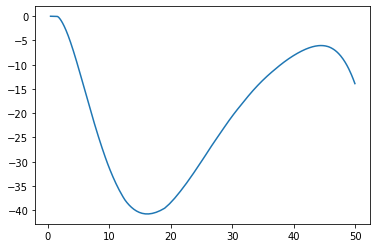

In [2]:
data = load("signal.npz")
lst = data.files
for item in lst:
    print(item)
    print(data[item])

nu = data['nu']
nu_50 = nu[nu<50]
nu6 = nu_50*1E6

Tsig = data['Tsig']
Tsig_50 = Tsig[nu<50]
Tsig3 = Tsig_50*1E3      # unit of mk

plt.plot(nu_50,Tsig3)
length = len(nu_50)
print(nu_50)
print(Tsig_50)

In [3]:
nu0 = 20E6 #hz
def func(x,a,b):
    return (40000+a)*(x/nu0)**(-2.5+b)             #without pre weighting with nu^(-2.5)
def func2(x,a,b,Amp):
    return (((40000+a)*(x/nu0)**(-2.5+b))+Amp)/((40000)*(x/nu0)**(-2.5))    #with pre weighting with nu^(-2.5)

In [11]:
T2 = func(nu6,0,0)     #T2 is the foreground from trivial power law
weight = (40000)*(nu6/nu0)**(-2.5)
Tdata = (T2 + Tsig_50)
T_wdata = (T2 + Tsig_50)/ weight                 # T_wdata is foreground + signal, and scaled by nu6^(-2.5)
#print(Tdata)
#plt.plot(nu_50,T_wdata,'b-',label = 'data')
#print(np.mean(T2))

[4.64599896e+08 4.63457837e+08 4.62317460e+08 ... 4.08906920e+03
 4.07734576e+03 4.05402636e+03]
[ 215.04690896  132.66892923 -106.41308716 ...  -35.37161121  -57.53002918
  117.5416303 ]


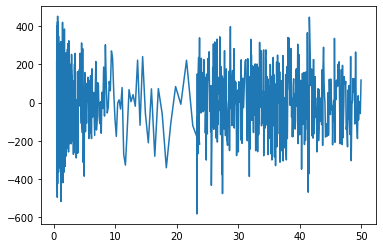

In [5]:
# Power calculation for noise.

Power = sum(Tdata**2)/len(Tsig_50)
SNR = 1000000000000            #I'm not sure if I can take this,  but the reason I chose this so that noise doesn't get to 
                               # values to the signal at higher frequencies
Power_noise = Power/SNR
mean_noise = 0
noise = np.random.normal(mean_noise,np.sqrt(Power_noise),len(Tsig_50))
plt.plot(nu_50,noise)
#plt.xlim(10,50)
#plt.ylim(-1,1)
print(Tdata)
print(noise)
##print(len(Tdata))
#print(len(nu_50))

## The noise above behaves in weird fashion near the expected signal frequency.

In [6]:
T_wndata = (Tdata + noise)/weight #T_wndata is weighted data with noise

In [7]:
popt,pcov = curve_fit(func2,nu6,T_wndata)             #curve-fitting done with the scaling of nu6^(-2.5)
popt

array([ 3.51534482e+01,  2.89018903e-04, -9.59082212e+00])

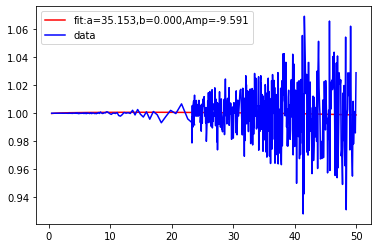

In [8]:
plt.plot(nu_50,func2(nu6,*popt),'r-',label = 'fit:a=%5.3f,b=%5.3f,Amp=%5.3f' %tuple(popt))
plt.plot(nu_50,T_wndata,'b-',label = 'data')
plt.legend() #with weighting (foreground+signal+noise)

## Is this a lot of noise?

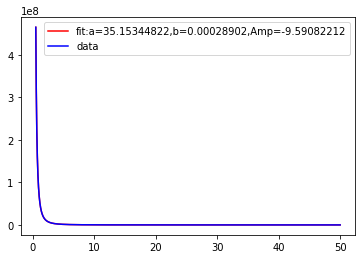

In [9]:
plt.plot(nu_50,func2(nu6,*popt)*weight,'r-',label = 'fit:a=%10.8f,b=%10.8f,Amp=%10.8f' %tuple(popt))
plt.plot(nu_50,T_wndata*weight,'b-',label = 'data')
plt.legend()  #without weighting (foreground + signal+noise)

# The green line has a lot of noise. So, there's a need to analyse using different method.

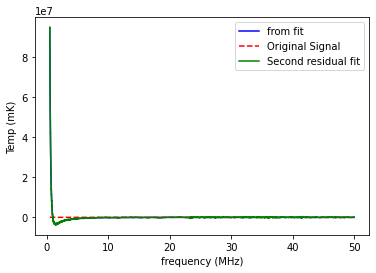

In [10]:
fit = func2(nu6,*popt)*weight
Tsig_fit = -1*(fit - T2)*1e3
Tsig_fit2 = (T_wndata*weight - fit)*1e3
plt.plot(nu_50,Tsig_fit,'b-',label='from fit')
plt.plot(nu_50,Tsig3,'r--',label = 'Original Signal')
plt.plot(nu_50,Tsig_fit2,'g',label = 'Second residual fit')
plt.xlabel("frequency (MHz)")
plt.ylabel("Temp (mK)")
plt.legend()
#plt.ylim(-100,50)  #original signal vs signal from fitting